# Plot PCs vs covariates

Same pipeline as `../../PCA/ipynb/05_Plot_PCs_vs_covariates.ipynb`.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext version_information
%version_information

Software versions
Python 2.7.12 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 2.6.32 431.3.1.el6.x86_64 x86_64 with centos 6.8 Final
Wed Jan 04 18:14:16 2017 EST

# Setup

In [89]:
# Input files
PDATA = "../../PCA/data/pData.pickle"
MAPPED_PC = "../data/samples_x_mapped_PCs.tsv"

# Load PC and phenotype data

In [24]:
pData = pd.read_pickle(PDATA)
pData.shape

(8525, 207)

In [28]:
pcData = pd.read_table(MAPPED_PC, index_col=0)
pcData.shape

(8525, 10)

In [90]:
df = pd.concat([pcData, pData], axis=1)
df.shape

(8525, 217)

# Def: Plot PC vs covariates

In [270]:
def plot_pc_vs_covariate(df, tissue, pc, covar, hue=None, style='darkgrid', rotate=False,  fit_reg=True):
    sns.set(style=style, font_scale=1.1)
    subdf = df[df.SMTS == tissue]
    
    if hue:
        subdf[hue].cat.remove_unused_categories(inplace=True)
    else:
        hue = None
    
    if subdf[covar].dtype.name == 'category':
        subdf[covar].cat.remove_unused_categories(inplace=True)
        n_categories = len(subdf[covar].cat.categories)
        if n_categories < 10:
            figsize = (1.2 * n_categories, 4)
            plt.figure(figsize=figsize)
            sns.boxplot(x=covar, y=pc, data=subdf, color='white', width=0.6)
            sns.swarmplot(x=covar, y=pc, hue=hue, data=subdf, alpha=.8, size=3)
            if hue:
                plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), fontsize=8)
        else:
            sns.stripplot(x=covar, y=pc, hue=hue, data=subdf)
            labels = plt.gca().get_xticklabels()
            plt.setp(labels, fontsize=6)
    else:
        sns.lmplot(x=covar, y=pc, hue=hue, data=subdf, fit_reg=fit_reg)
    
    plt.title(tissue)
    if rotate:
        labels = plt.gca().get_xticklabels()
        plt.setp(labels, rotation=90)

# Interactive plotter

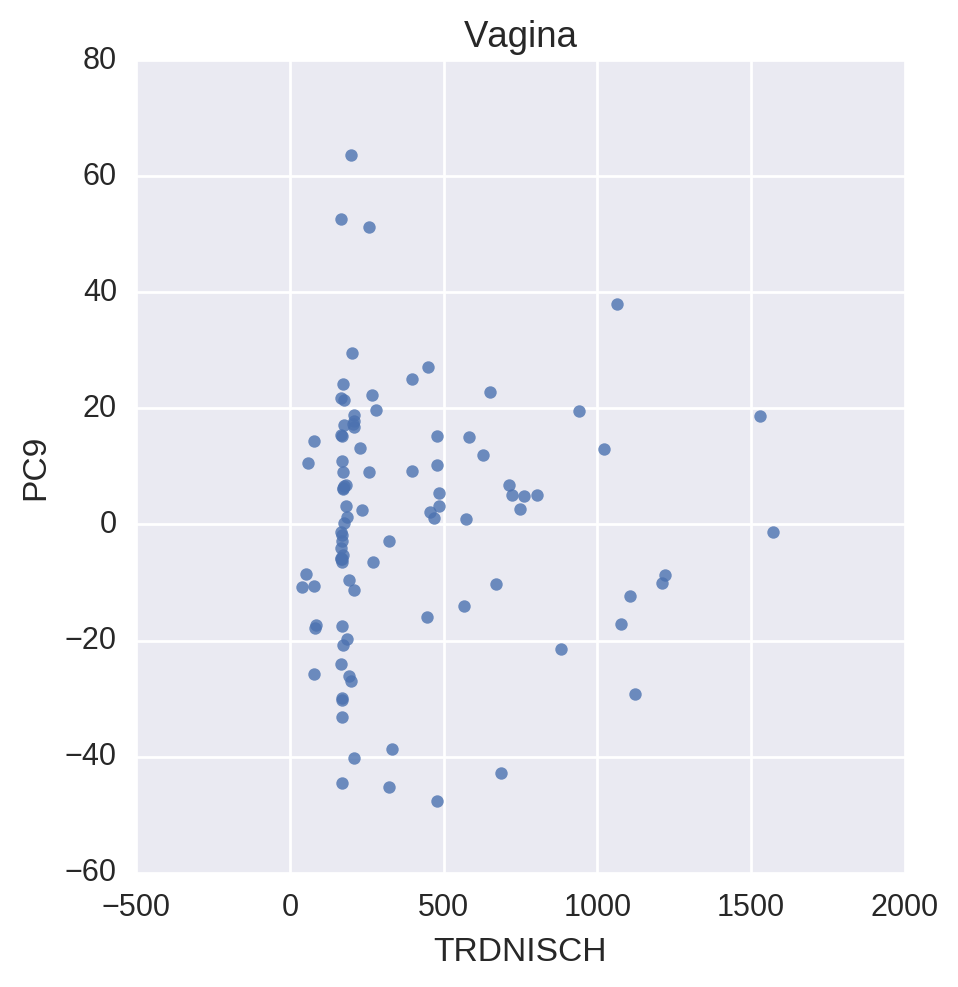

In [273]:
from ipywidgets import interact, fixed

tissues = df.SMTS.cat.categories.tolist()
variables = [None] + df.columns.tolist()
interact(plot_pc_vs_covariate, df=fixed(df), tissue=tissues, pc='PC1', covar='AGE', hue='', style=fixed('darkgrid'), rotate=False, fit_reg=True, __manual=True)

# Gallery

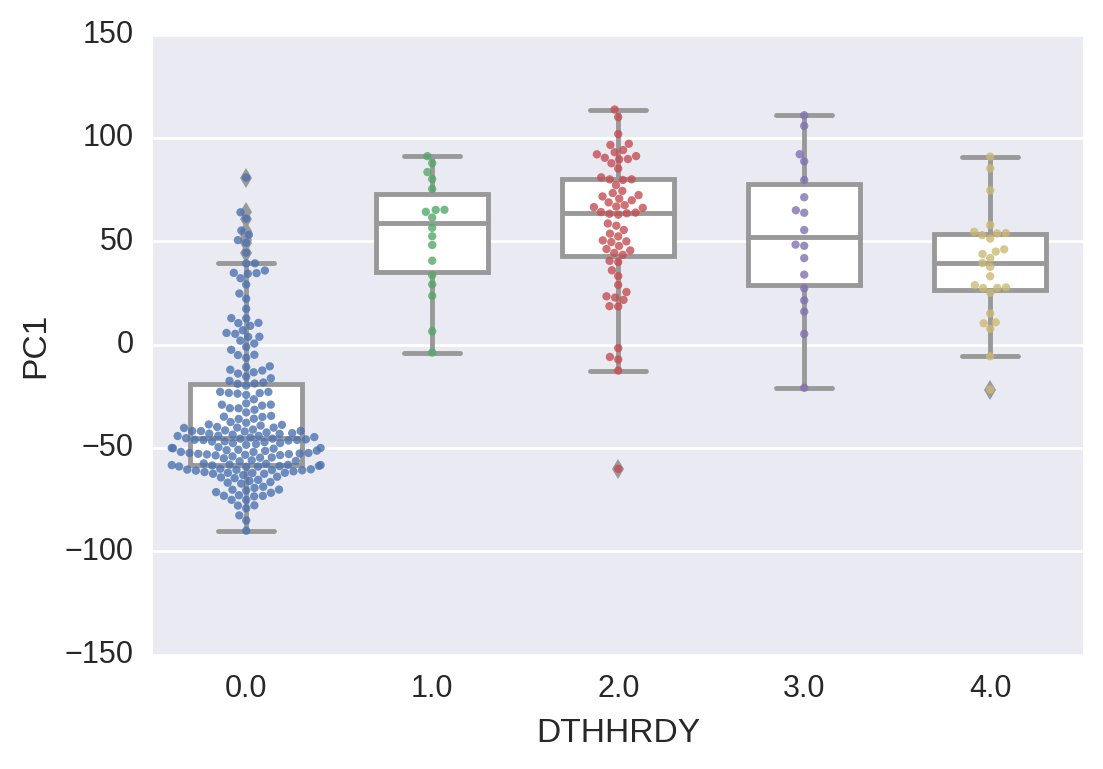

In [201]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'DTHHRDY')

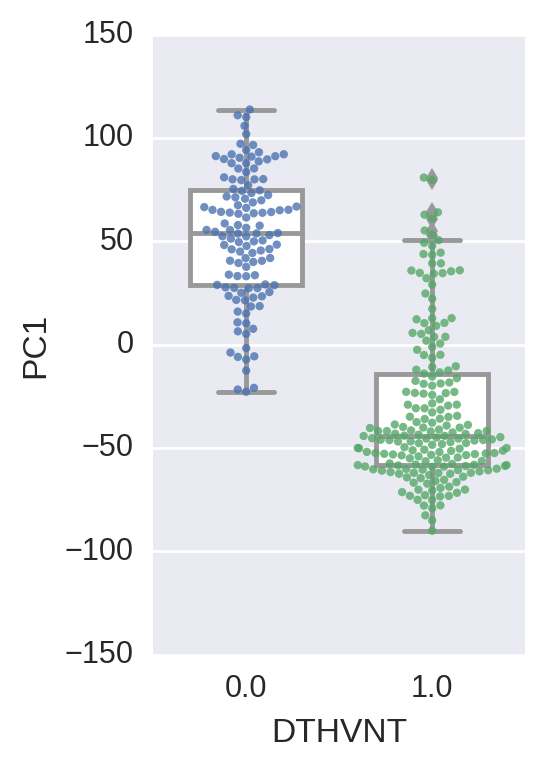

In [202]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'DTHVNT')

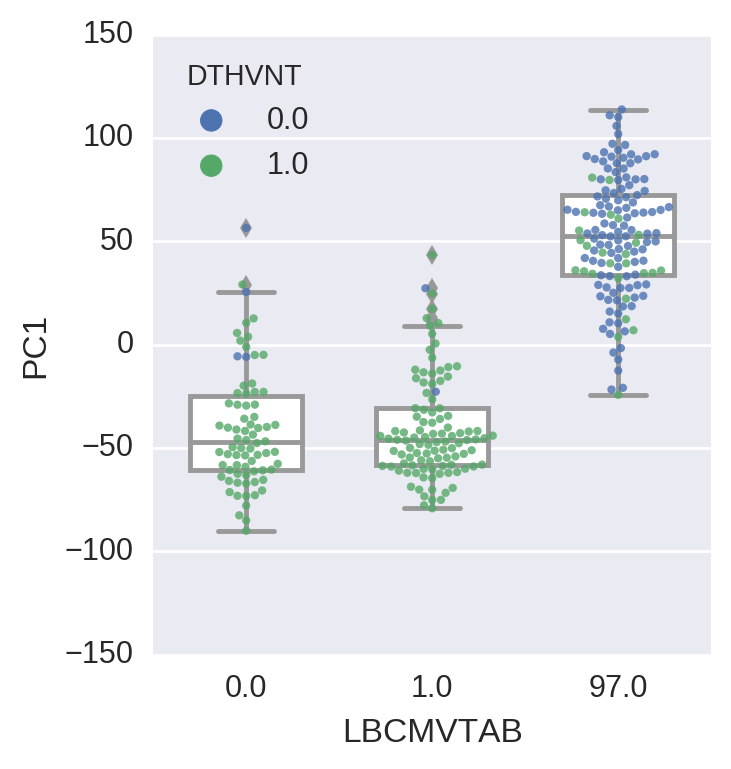

In [203]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'LBCMVTAB', hue='DTHVNT')

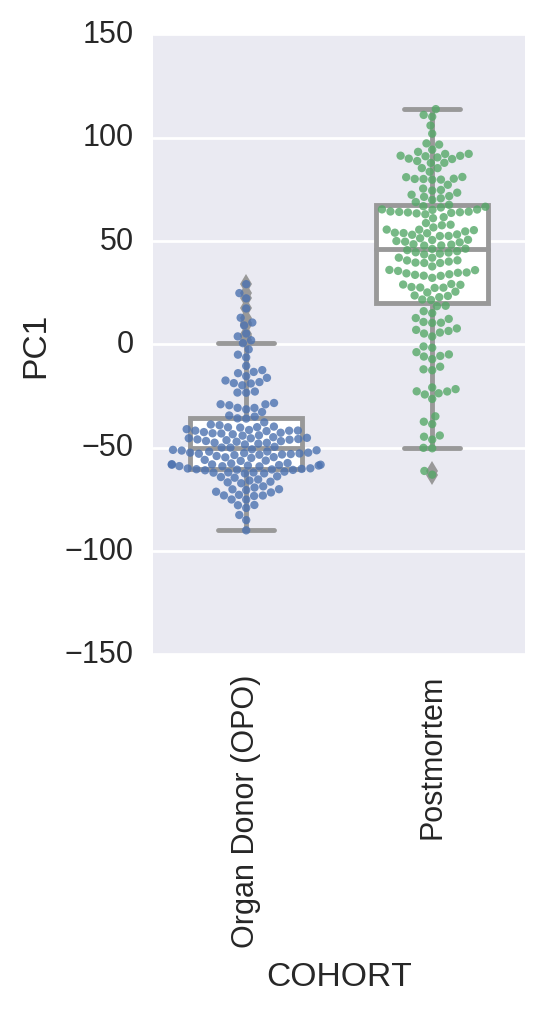

In [204]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'COHORT', rotate=True)

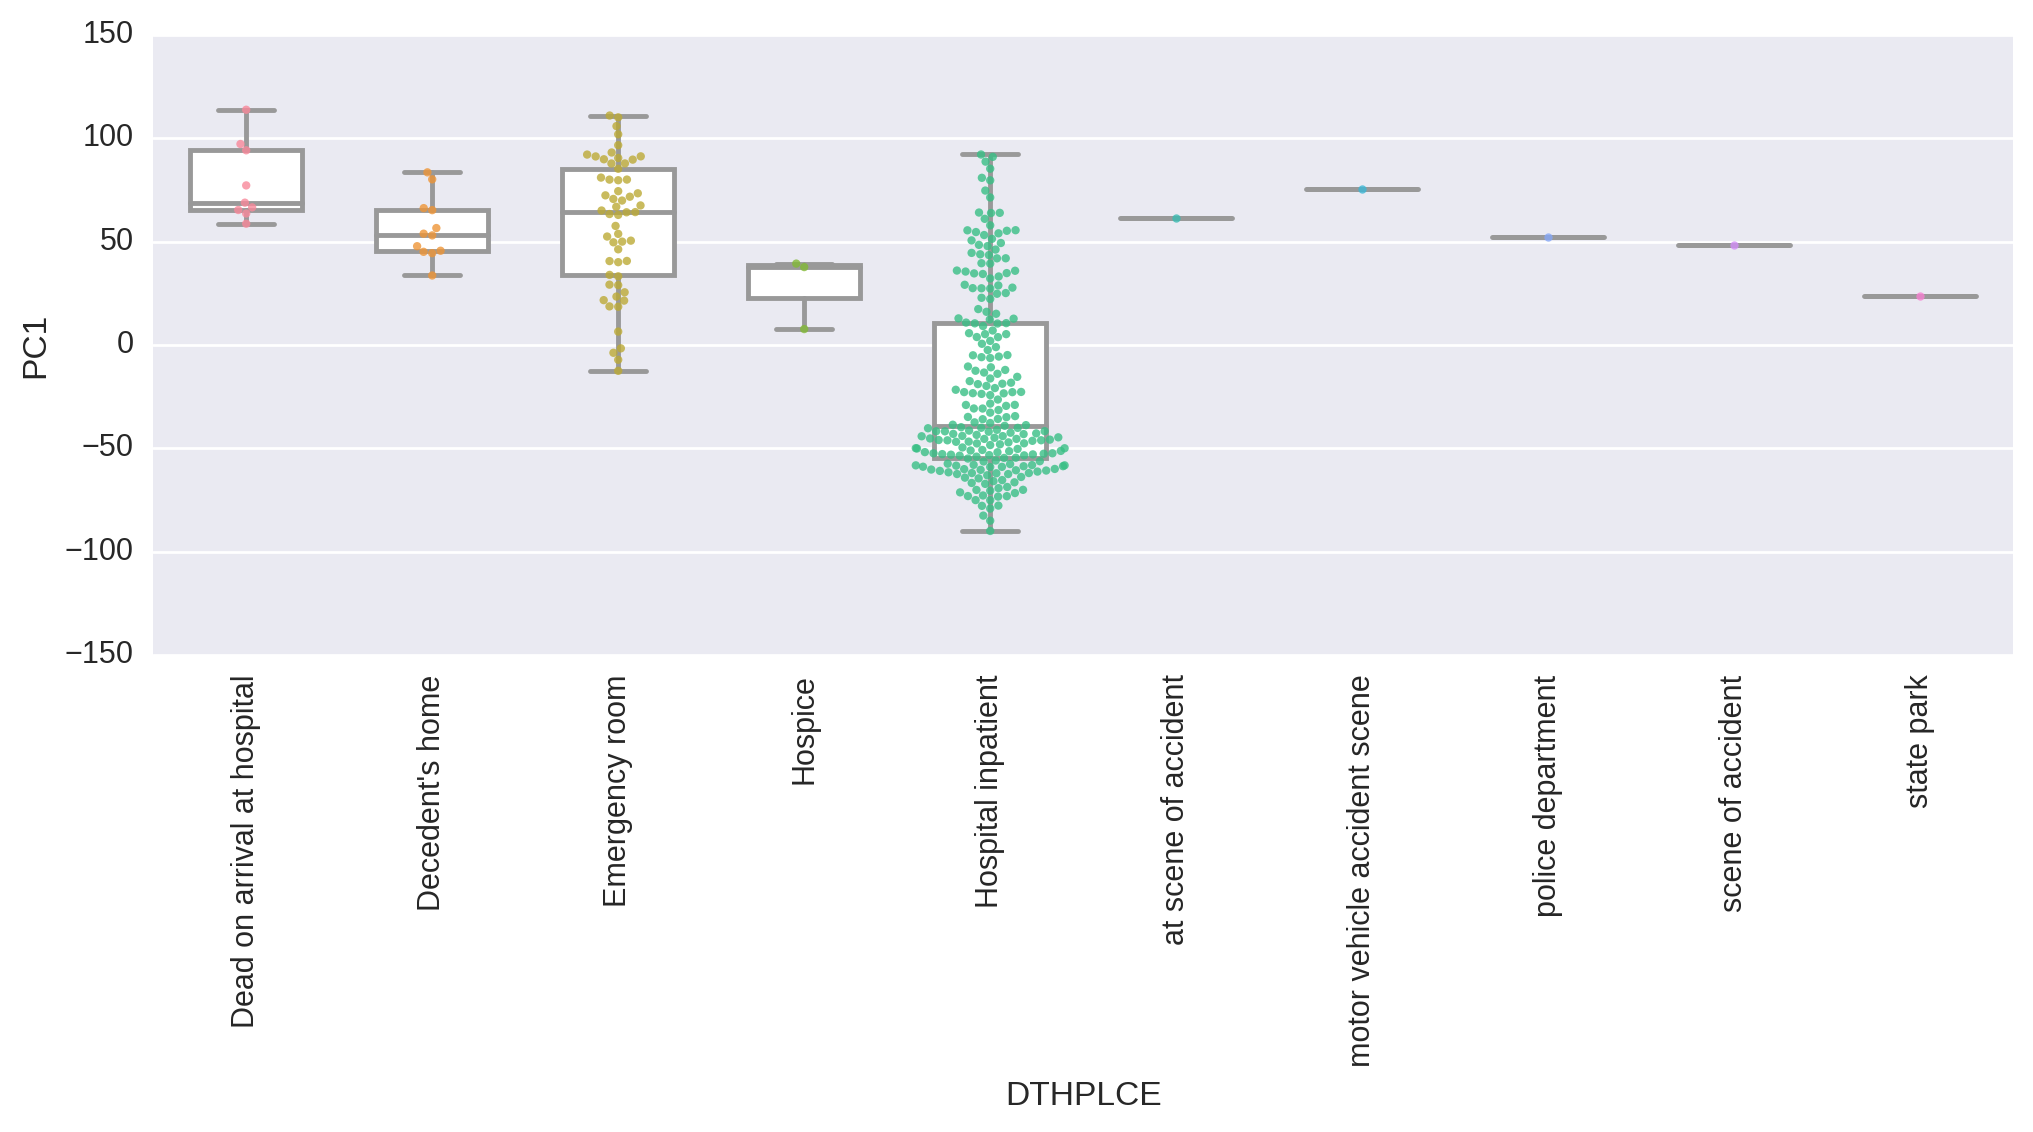

In [205]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'DTHPLCE', rotate=True)

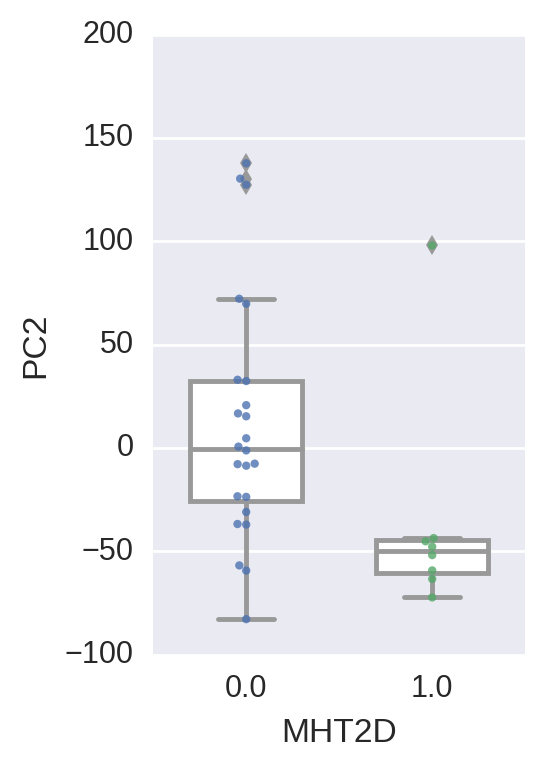

In [206]:
plot_pc_vs_covariate(df, 'Kidney', 'PC2', 'MHT2D')

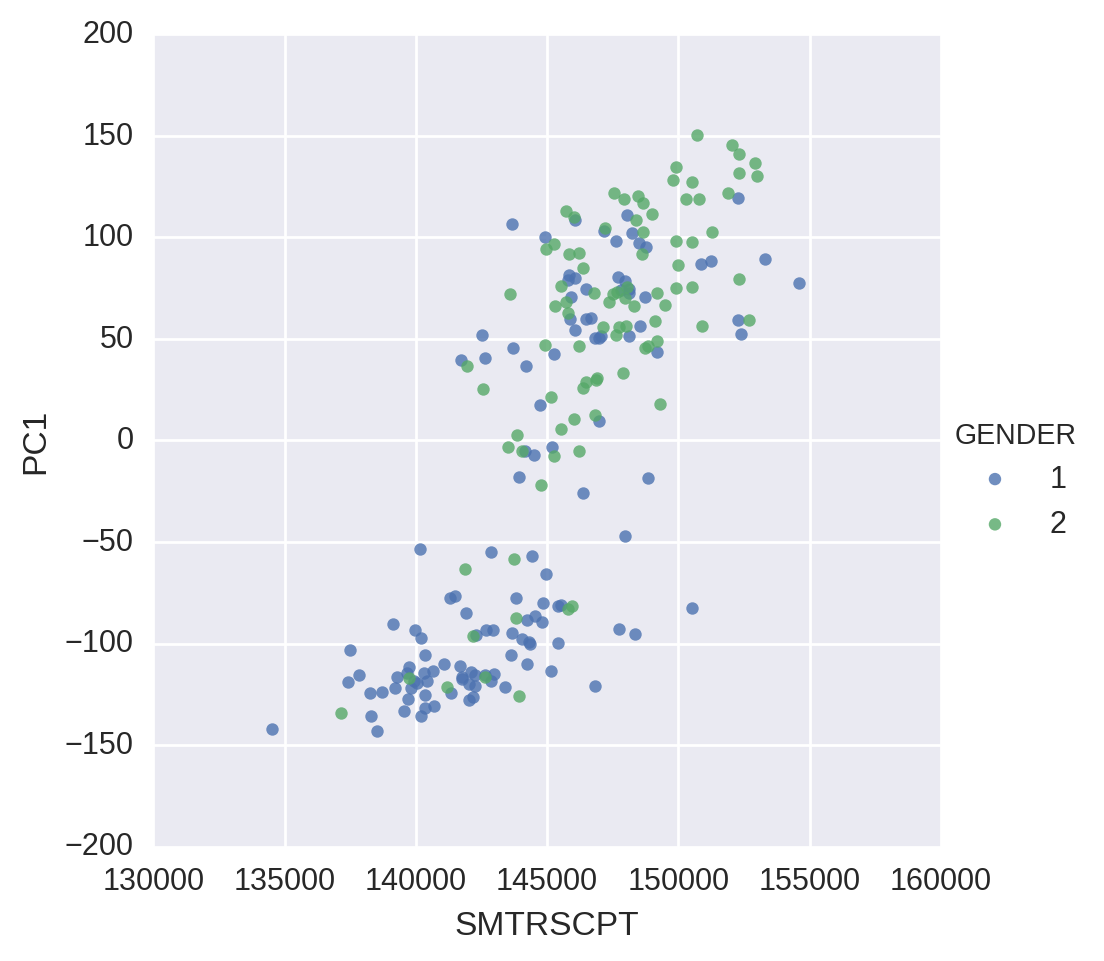

In [207]:
plot_pc_vs_covariate(df, 'Breast', 'PC1', 'SMTRSCPT', hue='GENDER', fit_reg=False)

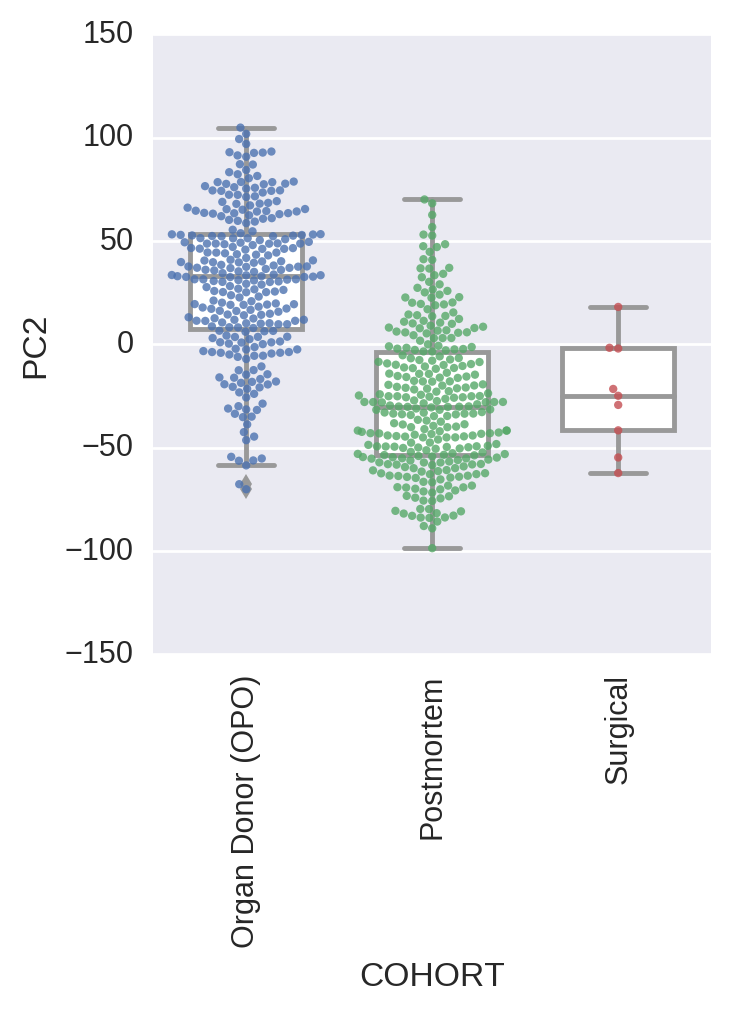

In [214]:
plot_pc_vs_covariate(df, 'Adipose Tissue', 'PC2', 'COHORT', rotate=True)

# Find non-linear relationships

In [272]:
INPUT = "../reports/Tissue-specific_MI_between_PCs_and_covariates.xlsx"
OUTPUT = "../reports/Nonlinear_PCR.xlsx"

with pd.ExcelFile(INPUT) as fin, pd.ExcelWriter(OUTPUT) as fout:
    for tissue in df.SMTS.cat.categories:
        subdf = df[df.SMTS == tissue]
        corr = subdf.corr().abs()
        cols = corr.columns
        df2 = pd.read_excel(fin, tissue).loc[cols, cols]
        df3 = ((df2 > corr) & (df2 > 0.05)).iloc[:, :10]
        df3.to_excel(fout, sheet_name=tissue)